In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
from collections import Counter
import math
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Load Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IR Assignments/A2/BBC News Train.csv')

In [ ]:
df.drop(columns = ['ArticleId'], inplace = True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df['Category'])
df.drop("Category", axis=1, inplace=True)
df["Category"] = label

#Defining preprocessing tasks

In [ ]:
def convert_lower(df):
    df['Text'] = df['Text'].map(str.lower)
    return df

In [ ]:
def remove_punctuations(df):
    df["Text"] = df['Text'].str.replace('[^\w\s]','')
    return df

In [ ]:
def remove_stopwords(df):
    df['Text'].apply(lambda x: [item for item in x if item not in stopwords])
    return df

In [ ]:
def tokenize(df):
    df['Text'] = df['Text'].apply(word_tokenize)
    return df

In [ ]:
def stemming(df):
    df['Text'] = df['Text'].apply(lambda x: [stemmer.stem(y) for y in x])
    return df

In [ ]:
def lemmatization(df):
    w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    df['Text'] = df['Text'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
    return df

In [ ]:
def preprocess(df):
    df = convert_lower(df)
    df = remove_punctuations(df)
    df = remove_stopwords(df)
    df = tokenize(df)    
    df = lemmatization(df)
    return df

In [ ]:
df = preprocess(df)

<ipython-input-42-46a016a6cd9d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["Text"] = df['Text'].str.replace('[^\w\s]','')


#TFIDF

General tf_idf function for given document

In [ ]:
def tf_idf(term, document, corpus):        
    tf = Counter(document)[term]
        
    n_docs_with_term = 0
    for doc in corpus:
        if term in doc:
            n_docs_with_term+=1    
    icf = math.log(len(corpus) / n_docs_with_term)
        
    return tf * icf

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3,random_state=11)
category_list = list(train_df['Category'].unique())

Making a corpus for the entire train_dataset

In [ ]:
def make_train_corpus(train_df):
  train_corpus = []
  for i in train_df['Text']:
      train_corpus.append(i)
  return train_corpus

Making corpus and words list for each class in train dataset



In [ ]:
def build_classwise_corpus(train_df,category_list):
  """Makes set(which is converted to a list) of words for each class: word_for_class and combines documents of each class as one whole document: corpus_for_class"""
  word_for_class = {}
  corpus_for_class = {}
  for cat in category_list:
    filter = train_df[train_df['Category'] == cat]
    words_ = []
    for i in filter['Text']:
      if cat in corpus_for_class.keys():
        corpus_for_class[cat].extend(i)
      else:
        corpus_for_class[cat] = i
      words_.extend(i)
    words_ = list(set(words_))
    if cat in word_for_class.keys():
      word_for_class[cat].extend(words_)
    else:
      word_for_class[cat] = words_
  return word_for_class,corpus_for_class

In [ ]:
def make_features_for_class(word_for_class,corpus_for_class,category_list,train_corpus,k):
  """makes dict of top-k tficf for each class: tfifc_for_class and combined feature which is basically stacked top-k features for all classes: features"""
  tfifc_for_class = {}
  features = set()
  for cat in category_list:
    print(cat, len(word_for_class[cat]), len(set(word_for_class[cat])))
    tfifc_word = {}
    for word in word_for_class[cat]:
      tfifc_word[word] = tf_idf(word,corpus_for_class[cat],train_corpus)
    tfifc_word_sort = dict(sorted(tfifc_word.items(), key=lambda item: item[1], reverse=True)) #sorts words according to their tficf scores
    top_k_class_features = list(tfifc_word_sort.keys())[:k] #select k top words
    tfifc_for_class[cat] = top_k_class_features
    features.update(top_k_class_features) #stacks features from all classes
  return tfifc_for_class, features

In [ ]:
def featurization_of_df(df_train,features, category_list):
  """converts df_train into feature vectors (term frequency of word in doc) fro the model to be able to use it"""
  train_x,train_y = [],[]
  for cat in category_list:
    filter = df_train[df_train["Category"] == cat]
    for docs in filter["Text"]:
        feature_for_doc = []
        term_frequency_doc = dict(Counter(docs))
        for i in features:
          if i in term_frequency_doc.keys():
            feature_for_doc.append(term_frequency_doc[i])
          else:
            feature_for_doc.append(0)
        train_x.append(feature_for_doc)
        train_y.append(cat)
  return train_x,train_y

In [ ]:
class Naive_Bayes():
  """Multinomial Naive Bayes approach used for document classification"""
  def __init__(self,train_x,train_y,test_x,test_y, category_list):
    self.train_x = train_x
    self.train_y = train_y
    self.test_x= test_x
    self.test_y = test_y
    self.category_list = category_list
    self.init_prob = {}
    self.conditional_prob = {}

  def fit(self):
    """Initial probability: frequency of class/total datapoints
      Conditional probability (probabiltiy of each feature for each class): sum of features for each class / sum(sum of feature for that class)"""
    count_class = dict(Counter(self.train_y))
    cumulative_feature = {}
    for i in self.category_list: #initializing cumulative_features

      self.init_prob[i] = count_class[i]/len(self.train_y) #frequency of class/total datapoints
      self.conditional_prob[i] = {} #initializing conditional_prob
      for j in range(len(self.train_x[0])):
        #initializing cumulative_feature
        if i in cumulative_feature.keys():
          cumulative_feature[i][j] = 0
        else:
          cumulative_feature[i] = {}
          cumulative_feature[i][j] = 0
         
    for i in range(len(self.train_y)):
      for j in range(len(self.train_x[0])):
        cumulative_feature[self.train_y[i]][j] += self.train_x[i][j] #adding features for each class

    lamda = 1 #to make sure no dividing by 0 happening
    

    for i in self.category_list:
      for j in range(len(self.train_x[0])):
        adjusted_cum = cumulative_feature[i][j] + lamda #adding lamda to adjust 0 error
        sum_of_features = sum(cumulative_feature[i].values()) + lamda * len(self.train_y) #adding lamba to all features to adjust 0 error
        conditional_probability = adjusted_cum/sum_of_features #cumulative_feature (tf)/sum_of_features (total_tf)
        self.conditional_prob[i][j] = conditional_probability

    return self.init_prob, self.conditional_prob

  def predict(self):
    """Using multinomial naive bayes to get predictions"""
    pred = []

    for i in self.test_x:
      class_prob = {}
      for cat in self.category_list:
        sum_of_feature_prob = 0
        for j in range(len(test_x[0])):
          if i[j] != 0:
            sum_of_feature_prob += i[j]*math.log10(self.conditional_prob[cat][j])
        class_prob[cat] = sum_of_feature_prob + math.log10(self.init_prob[cat])#log(probability of histogram)
      pred_class = max(zip(class_prob.values(), class_prob.keys()))[1] #class with maximum probability gets predicted
      pred.append(pred_class)
    return pred

  def eval(self,pred):
    correct = 0
    for i in range(len(pred)):
      if self.test_y[i] == pred[i]:
        correct+=1
    
    confusion_mat = [[0 for i in range(len(self.category_list))] for j in range(len(self.category_list))]
    for i in range(len(pred)):
      confusion_mat[pred[i]][test_y[i]] += 1

    confusion_mat = np.array(confusion_mat)
    f1 = {}
    for i in range(confusion_mat.shape[0]): #pred
      tp = 0
      fp = 0
      fn = 0

      tp = confusion_mat[i][i]
      precision = tp/confusion_mat[i].sum()
      recall = tp/confusion_mat.sum(axis=0)[i]

      f1[i] = (2*precision*recall)/(precision+recall)
    
    accuracy = correct/len(pred)
    #report = classification_report(self.test_y, pred, digits=3)
    return accuracy, confusion_mat,f1

In [ ]:
# corpus = make_train_corpus(df)
# train_word_for_class, train_corpus_for_class = build_classwise_corpus(df,category_list)
# tfifc_for_class, features = make_features_for_class(train_word_for_class, train_corpus_for_class,category_list,corpus,50)

In [ ]:
# X,y = featurization_of_df(df,features,category_list)

In [ ]:
# import pickle
# with open("Xy_TFIDF.pkl", 'wb') as f:
#   d = {'X':X,'y':y}
#   pickle.dump(d,f)

In [ ]:
import pickle
with open('/content/drive/MyDrive/IR Assignments/A2/Q2_TFIDF.pkl', 'rb') as f:
    d = pickle.load(f)

In [ ]:
X = d['X']
y = d['y']

##70:30 split

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(np.array(X),np.array(y),test_size=0.3,random_state = 11)
model = Naive_Bayes(train_x,train_y,test_x,test_y, category_list)
_,__ = model.fit()
pred = model.predict()

In [ ]:
acc, cm, f1 = model.eval(pred)

In [ ]:
print("Accuracy: ",acc,'\n',f1)

Accuracy:  0.9574944071588367 
 {0: 0.9494949494949495, 1: 0.9500000000000001, 2: 0.9523809523809523, 3: 0.9813084112149533, 4: 0.948051948051948}


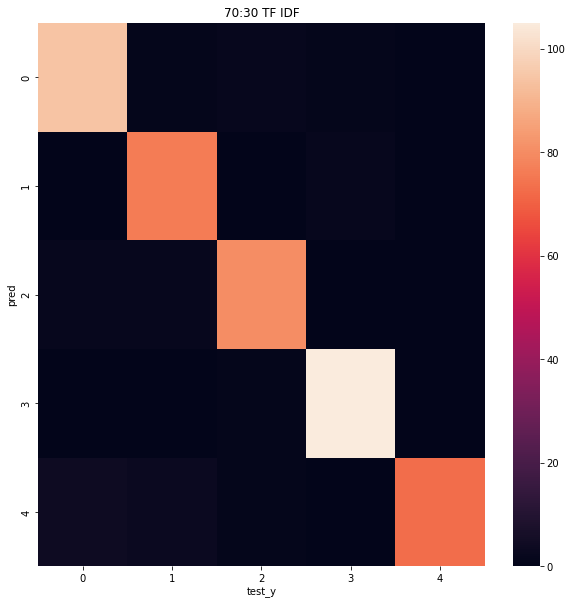

In [ ]:
plt.figure(figsize=(10,10))
sbn.heatmap(cm)
plt.title("70:30 TF IDF")
plt.ylabel("pred")
plt.xlabel("test_y")
plt.show()

##80:20 split

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(np.array(X),np.array(y),test_size=0.2,random_state = 11)
model = Naive_Bayes(train_x,train_y,test_x,test_y, category_list)
_,__ = model.fit()
pred = model.predict()

In [ ]:
acc, cm, f1 = model.eval(pred)

In [ ]:
print("Accuracy: ",acc,'\n',f1)

Accuracy:  0.9563758389261745 
 {0: 0.943089430894309, 1: 0.9523809523809523, 2: 0.9508196721311476, 3: 0.9801324503311258, 4: 0.9473684210526316}


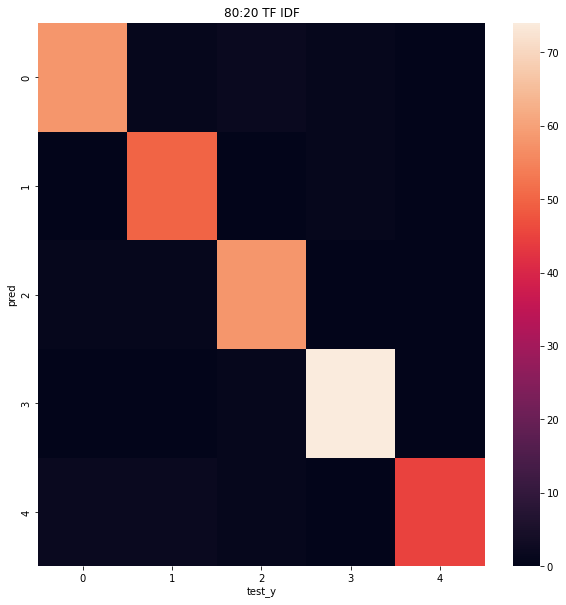

In [ ]:
plt.figure(figsize=(10,10))
sbn.heatmap(cm)
plt.title("80:20 TF IDF")
plt.ylabel("pred")
plt.xlabel("test_y")
plt.show()

##50:50 split

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(np.array(X),np.array(y),test_size=0.5,random_state = 11)
model = Naive_Bayes(train_x,train_y,test_x,test_y, category_list)
_,__ = model.fit()
pred = model.predict()

In [ ]:
acc, cm, f1 = model.eval(pred)

In [ ]:
print("Accuracy: ",acc,'\n',f1)

Accuracy:  0.9610738255033557 
 {0: 0.9544072948328267, 1: 0.9541984732824427, 2: 0.9556313993174061, 3: 0.9827586206896551, 4: 0.9534883720930232}


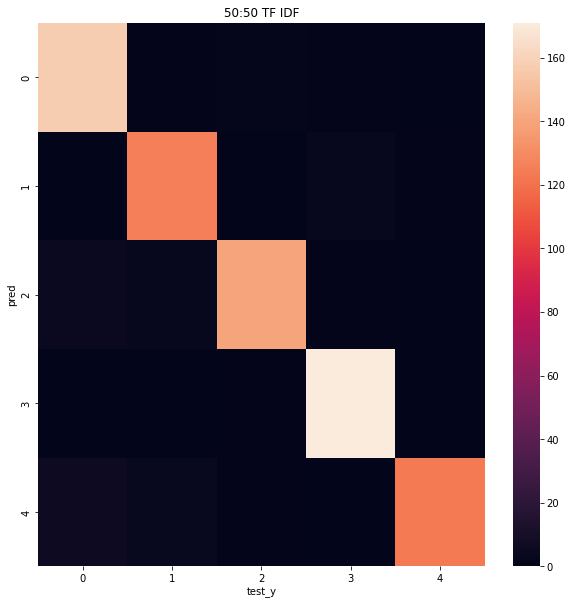

In [ ]:
plt.figure(figsize=(10,10))
sbn.heatmap(cm)
plt.title("50:50 TF IDF")
plt.ylabel("pred")
plt.xlabel("test_y")
plt.show()

#TFICF

In [ ]:
def tf_icf(term, document, class_for_word, category_list):    
    """This should be icf"""    
    tf = Counter(document)[term]
        
    n_classes_with_term = len(class_for_word[term])
    icf = math.log(len(category_list) / n_classes_with_term)
        
    return tf * icf

In [ ]:
def build_classwise_corpus(train_df,category_list):
  """Makes set(which is converted to a list) of words for each class: word_for_class and combines documents of each class as one whole document: corpus_for_class"""
  word_for_class = {}
  corpus_for_class = {}
  class_for_word = {}
  for cat in category_list:
    filter = train_df[train_df['Category'] == cat]
    words_ = []
    for i in filter['Text']:
      if cat in corpus_for_class.keys():
        corpus_for_class[cat].extend(i)
      else:
        corpus_for_class[cat] = i
      words_.extend(i)
    words_ = list(set(words_))
    for word in words_:
      if word in class_for_word.keys():
        class_for_word[word].append(cat)
      else:
        class_for_word[word] = [cat]
    if cat in word_for_class.keys():
      word_for_class[cat].extend(words_)
    else:
      word_for_class[cat] = words_
  return word_for_class,corpus_for_class, class_for_word

In [ ]:
def make_features_for_class(word_for_class,corpus_for_class,class_for_word, category_list,train_corpus,k):
  """makes dict of top-k tficf for each class: tfifc_for_class and combined feature which is basically stacked top-k features for all classes: features"""
  tfifc_for_class = {}
  features = set()
  for cat in category_list:
    print(cat, len(word_for_class[cat]), len(set(word_for_class[cat])))
    tfifc_word = {}
    for word in word_for_class[cat]:
      tfifc_word[word] = tf_icf(word,corpus_for_class[cat],class_for_word,category_list)
    print(cat)
    tfifc_word_sort = dict(sorted(tfifc_word.items(), key=lambda item: item[1], reverse=True)) #sorts words according to their tficf scores
    top_k_class_features = list(tfifc_word_sort.keys())[:k] #select k top words
    tfifc_for_class[cat] = top_k_class_features
    features.update(top_k_class_features) #stacks features from all classes
  return tfifc_for_class, features

In [ ]:
# corpus = make_train_corpus(df)
# train_word_for_class, train_corpus_for_class, class_for_word = build_classwise_corpus(df,category_list)
# tfifc_for_class, features = make_features_for_class(train_word_for_class, train_corpus_for_class,class_for_word,category_list,corpus,50)

In [ ]:
# X,y = featurization_of_df(df,features,category_list)

In [ ]:
# import pickle
# with open("Xy_TFICF.pkl", 'wb') as f:
# #   d = {'X':X,'y':y}
#   pickle.dump(d,f)

In [ ]:
import pickle #to save time running the above feature extraction we have stored the pickle files
with open("/content/drive/MyDrive/IR Assignments/A2/Q2_TFICF.pkl", 'rb') as f:
  d = pickle.load(f)
X,y = d['X'],d['y']

##70:30 split

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(np.array(X),np.array(y),test_size=0.3,random_state = 11)
model = Naive_Bayes(train_x,train_y,test_x,test_y, category_list)
_,__ = model.fit()
pred = model.predict()

In [ ]:
acc, cm, f1 = model.eval(pred)

In [ ]:
print("Accuracy: ",acc,'\n',f1)

Accuracy:  0.9507829977628636 
 {0: 0.9424083769633509, 1: 0.9426751592356688, 2: 0.9585798816568047, 3: 0.9553571428571429, 4: 0.9542483660130718}


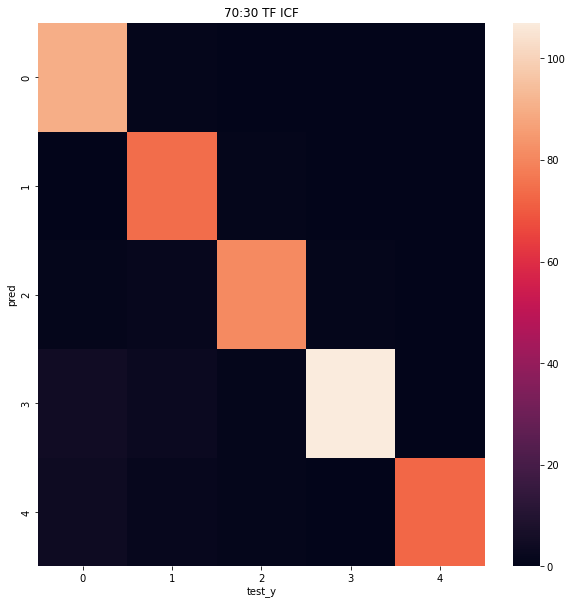

In [ ]:
plt.figure(figsize=(10,10))
sbn.heatmap(cm)
plt.title("70:30 TF ICF")
plt.ylabel("pred")
plt.xlabel("test_y")
plt.show()

##80:20 split

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(np.array(X),np.array(y),test_size=0.2,random_state = 11)
model = Naive_Bayes(train_x,train_y,test_x,test_y, category_list)
_,__ = model.fit()
pred = model.predict()

In [ ]:
acc, cm, rep = model.eval(pred)

In [ ]:
print("Accuracy: ",acc,'\n',rep)

Accuracy:  0.9496644295302014 
 {0: 0.9076923076923077, 1: 0.9523809523809523, 2: 0.9752066115702479, 3: 0.9523809523809524, 4: 0.967741935483871}


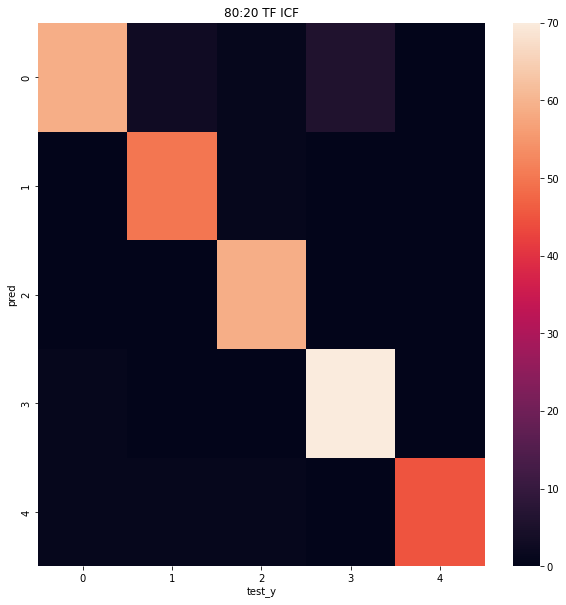

In [ ]:
plt.figure(figsize=(10,10))
sbn.heatmap(cm)
plt.title("80:20 TF ICF")
plt.ylabel("pred")
plt.xlabel("test_y")
plt.show()

##50:50 split

In [ ]:
train_x,test_x,train_y,test_y = train_test_split(np.array(X),np.array(y),test_size=0.5,random_state = 11)
model = Naive_Bayes(train_x,train_y,test_x,test_y, category_list)
_,__ = model.fit()
pred = model.predict()

In [ ]:
acc, cm, f1 = model.eval(pred)

In [ ]:
print("Accuracy: ",acc,'\n',f1)

Accuracy:  0.9489932885906041 
 {0: 0.950920245398773, 1: 0.9453125000000001, 2: 0.9477351916376306, 3: 0.9505494505494505, 4: 0.9494163424124513}


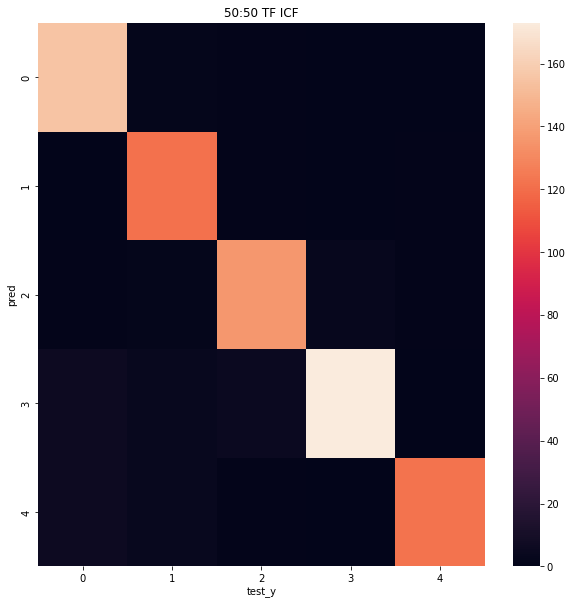

In [ ]:
plt.figure(figsize=(10,10))
sbn.heatmap(cm)
plt.title("50:50 TF ICF")
plt.ylabel("pred")
plt.xlabel("test_y")
plt.show()